# Librerías y configuración

In [54]:
import os
import time

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns
import tqdm.notebook as tqdm
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel, LdaMulticore
from wordcloud import WordCloud

os.chdir(
    "C:/Users/luism/Documents/Programacion_local/Clase/4o Año/Descubrimiento Datos Complejos/DCDC-Proyecto-Stocks"
)


os.listdir()

SEED = 289995

In [3]:
# Descargar recursos necesarios de NLTK
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\luism\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luism\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\luism\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\luism\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

# Cargar datos

In [4]:
df_completo: pd.DataFrame = pd.read_pickle(
    r"C:\Users\luism\Documents\Programacion_local\Clase\4o Año\Descubrimiento Datos Complejos\DCDC-Proyecto-Stocks\notebooks\Luis\mineria_datos\Datos\03_df_noticias_fecha_procesado.pkl"
)

In [5]:
display(df_completo.head())
print(df_completo.shape)

,date,month,news,news_processed
0,2012-01-03 00:00:00+00:00,2012-01,'Mad Money Lightning Round': Stay Long Sandridge,"[mad, money, lightning, round, stay, long, san..."
1,2012-01-03 00:00:00+00:00,2012-01,Cramer's 'Mad Money' Recap: Betting Against th...,"[cramers, mad, money, recap, betting, bear, fi..."
2,2012-01-03 00:00:00+00:00,2012-01,'Mad Money Lightning Round': Stay Long Sandridge,"[mad, money, lightning, round, stay, long, san..."
3,2012-01-03 00:00:00+00:00,2012-01,BioLineRx Announces Initiation of CE Mark Regi...,"[biolinerx, announces, initiation, mark, regis..."
4,2012-01-03 00:00:00+00:00,2012-01,Hearing Rumors of the Death of Fidel Castro,"[hearing, rumor, death, fidel, castro]"


(2303734, 4)


# Samplear y preprocesar

In [ ]:
SAMPLE_SIZE = 5000

In [ ]:
# Muestra un subconjunto del dataframe original
sampled_df = (
    df_completo.sample(n=SAMPLE_SIZE, random_state=SEED)
    .sort_values("date")
    .reset_index(drop=True)
)

# Imprime la longitud original y la longitud muestreada del dataframe
print(
    "Longitud original:",
    len(df_completo),
    "Longitud muestreada:",
    len(sampled_df),
    f" - {len(sampled_df) / len(df_completo):.4f}% del total",
)

In [ ]:
# Crea un diccionario a partir de las noticias procesadas
dictionary = Dictionary(
    tqdm.tqdm(sampled_df["news_processed"], desc="Creando diccionario")
)
dictionary.filter_extremes(no_below=5, no_above=0.5)
print("\nTamaño del vocabulario:", len(dictionary))

# Crea un corpus a partir del diccionario
corpus = [
    dictionary.doc2bow(doc)
    for doc in tqdm.tqdm(sampled_df["news_processed"], desc="Creando corpus")
]

# Encontrar mejor n_topics por coherencia de topics

In [ ]:
# Alamcenamos los textos procesados para le modelo de Coherencia
texts = sampled_df["news_processed"].tolist()

# Lista de números de tópicos a probar
topic_nums = list(range(2, 60, 3))

coherence_scores = []

for num_topics in tqdm.tqdm(topic_nums, desc="Procesando número de tópicos"):
    start_time_n_topics = time.time()
    # Entrenar el modelo LDA
    dtm = LdaMulticore(
        corpus=corpus,
        num_topics=num_topics,
        id2word=dictionary,
        passes=10,
        random_state=SEED,
        workers=12,
    )

    # Calcular la coherencia
    coherence_model = CoherenceModel(
        model=dtm, texts=texts, dictionary=dictionary, coherence="c_v"
    )
    coherence_score = coherence_model.get_coherence()
    coherence_scores.append(coherence_score)

    # Tiempo final
    end_time_n_topics = time.time()
    elapsed_time_n_topics = time.strftime(
        "%H:%M:%S", time.gmtime(end_time_n_topics - start_time_n_topics)
    )
    print(
        f"Tiempo para {num_topics} tópicos: {elapsed_time_n_topics}, Coherencia: {coherence_score}"
    )

In [ ]:
# Plot coherence scores
fig, ax = plt.subplots(figsize=(15, 6))
plt.bar(topic_nums, coherence_scores)
plt.plot(topic_nums, coherence_scores, marker="o", linestyle="--")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores for Different Numbers of Topics")
plt.grid(axis="y")
plt.xticks(topic_nums)
plt.show()

# Probar con todo el dataset el n_topics resultante

In [11]:
# Crea un diccionario a partir de las noticias procesadas
dictionary = Dictionary(
    tqdm.tqdm(df_completo["news_processed"], desc="Creando diccionario")
)
dictionary.filter_extremes(no_below=5, no_above=0.5)
print("\nTamaño del vocabulario:", len(dictionary))

# Crea un corpus a partir del diccionario
corpus = [
    dictionary.doc2bow(doc)
    for doc in tqdm.tqdm(df_completo["news_processed"], desc="Creando corpus")
]

texts = df_completo["news_processed"].tolist()

Creando diccionario:   0%|          | 0/2303734 [00:00<?, ?it/s]


Tamaño del vocabulario: 81064


Creando corpus:   0%|          | 0/2303734 [00:00<?, ?it/s]

In [ ]:
num_topics = 5

In [ ]:
start_time = time.time()
print(f"Start time: {time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(start_time))}")

dtm = LdaMulticore(
    corpus=corpus,
    num_topics=num_topics,
    id2word=dictionary,
    passes=10,
    random_state=SEED,
    workers=12,
)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time LDA: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}")


# Calcular la coherencia
start_time = time.time()
coherence_model = CoherenceModel(
    model=dtm, texts=texts, dictionary=dictionary, coherence="c_v"
)
coherence_score = coherence_model.get_coherence()
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Elapsed time Coherence: {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}")

# Guardar modelo

In [ ]:
dtm.save("notebooks/Luis/mineria_datos/models/lda_model/lda_model")

In [ ]:
coherence_model.save("notebooks/Luis/mineria_datos/models/coherence_lda/coherence_model")

# Resultados

In [6]:
dtm : LdaMulticore = LdaMulticore.load("notebooks/Luis/mineria_datos/models/lda_model/lda_model")
coherence_model : CoherenceModel = CoherenceModel.load("notebooks/Luis/mineria_datos/models/coherence_lda/coherence_model")

num_topics = 5

In [7]:
coherence_score = coherence_model.get_coherence()

print(f"Coherence Score: {coherence_score:.3f}")

Coherence Score: 0.533


In [8]:
dtm.num_topics

5

In [26]:
for topic_n, topic_weigths_str in dtm.print_topics(num_topics=num_topics, num_words=5):

    print(f"Topic {topic_n}: {topic_weigths_str}")

Topic 0: 0.032*"earnings" + 0.029*"stock" + 0.017*"share" + 0.014*"price" + 0.013*"report"
Topic 1: 0.058*"aapl" + 0.057*"amzn" + 0.042*"googl" + 0.034*"spy" + 0.029*"nflx"
Topic 2: 0.021*"aapl" + 0.020*"amzn" + 0.017*"msft" + 0.016*"tsla" + 0.016*"stock"
Topic 3: 0.061*"tsla" + 0.018*"aapl" + 0.011*"amzn" + 0.011*"tslaq" + 0.010*"like"
Topic 4: 0.030*"tsla" + 0.024*"tesla" + 0.015*"aapl" + 0.013*"apple" + 0.012*"car"


In [9]:
# Barplot topics most important words

topic_weigths = []

for topic_n, topic_weigths_str in dtm.print_topics(num_topics=num_topics, num_words=5):
    
    weigths = topic_weigths_str.split(" + ")
    weigths_topic_n = []
    for weight in weigths:
        
        tup = weight.split("*")
        tup = (float(tup[0]), tup[1].replace("\"", ""))

        weigths_topic_n.append(tup)
    topic_weigths.append(weigths_topic_n)    
topic_weigths

fig = go.Figure()

for i, topic in enumerate(topic_weigths):
    x = [word for weight, word in topic]
    y = [weight for weight, word in topic]
    fig.add_trace(go.Bar(x=x, y=y, name=f"Topic {i+1}"))

fig.update_layout(barmode="group", title="Top 5 words for each topic", xaxis_title="Words", yaxis_title="Weights")
fig.show()

In [ ]:
# Topics distribution in the corpus
print("Len corpus:", len(corpus))
topics_distribution = [dtm.get_document_topics(doc) for doc in tqdm.tqdm(corpus)]

In [33]:
# Calculate average weight for each topic
topic_weights = np.zeros(num_topics)
for dist in topics_distribution:
    for topic_id, weight in dist:
        topic_weights[topic_id] += weight
topic_weights /= len(corpus)

# Create visualization
fig = go.Figure(data=[
    go.Bar(
        x=[f"Topic {i+1}" for i in range(num_topics)],
        y=topic_weights
    )
])

fig.update_layout(
    title="Topic Distribution Across Corpus",
    xaxis_title="Topics",
    yaxis_title="Average Weight",
    yaxis_range=[0,1]
)
fig.show()

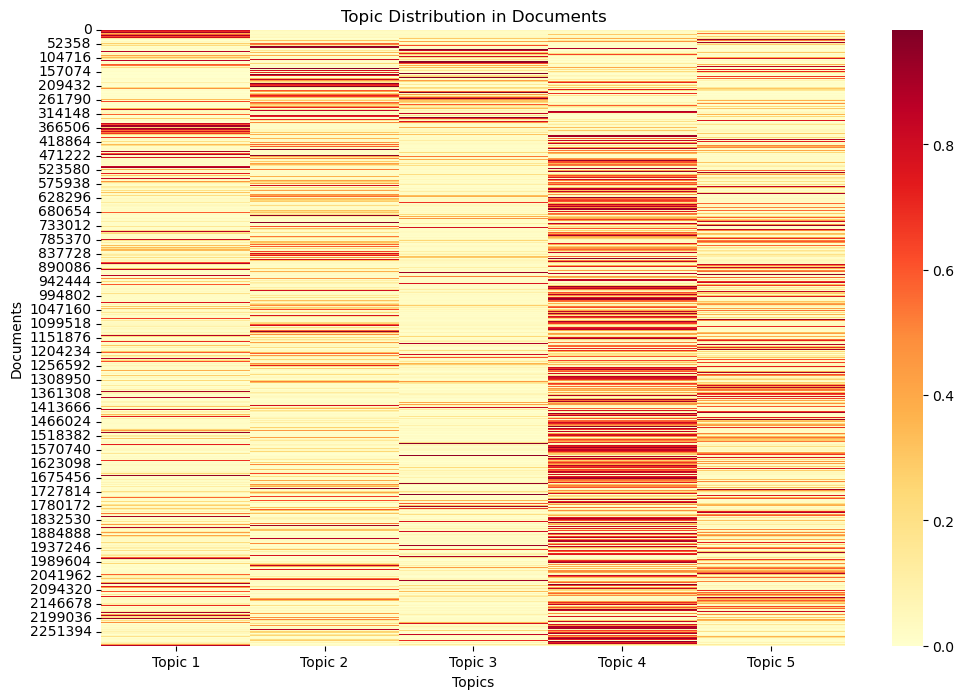

In [47]:
first_n = len(corpus)

doc_topics = np.zeros((len(corpus[:first_n]), num_topics))
for i in range(len(corpus[:first_n])):
    topic_dist = topics_distribution[i]
    for topic_id, weight in topic_dist:
        doc_topics[i, topic_id] = weight

# Create heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    doc_topics[:first_n],  # Show first 50 documents
    cmap='YlOrRd',
    xticklabels=[f'Topic {i+1}' for i in range(num_topics)],
)
plt.title('Topic Distribution in Documents')
plt.xlabel('Topics')
plt.ylabel('Documents')
plt.show()

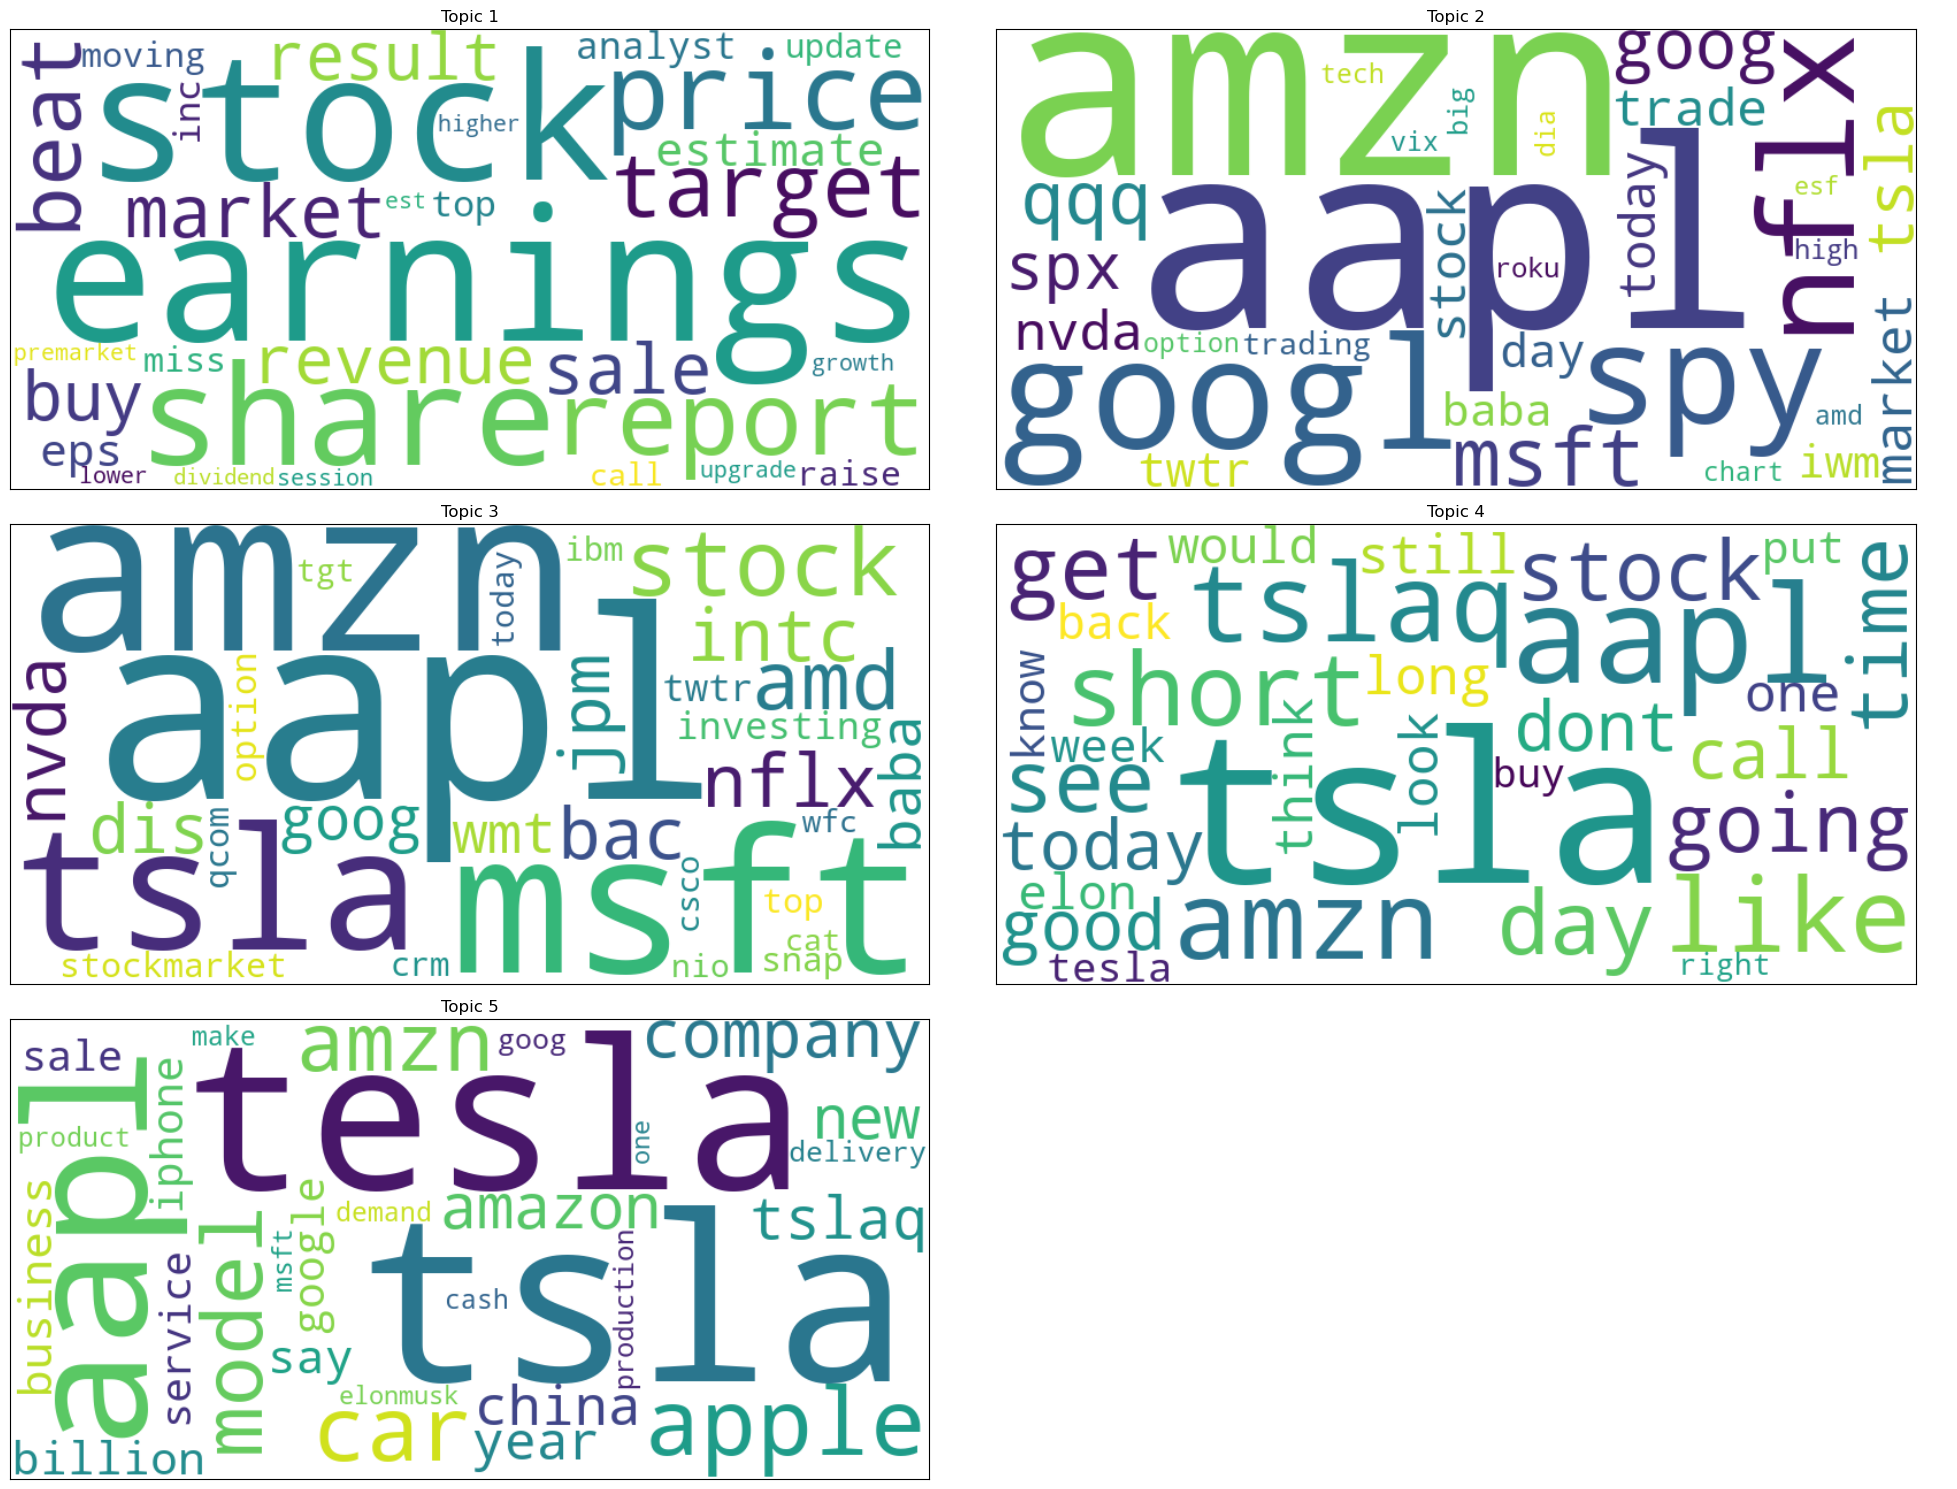

In [52]:
fig, axes = plt.subplots(3, 2, figsize=(20, 15))

# Create word cloud for each topic
for t in range(num_topics):
    # Get word weights for topic
    words = dict(dtm.show_topic(t, 30))
    
    # Generate word cloud
    wordcloud = WordCloud(
        background_color='white',
        width=800,
        height=400
    ).generate_from_frequencies(words)
    
    ax = axes[t // 2, t % 2]
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_title(f'Topic {t+1}')

# Turn off the axis for the last subplot
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()